In [220]:
import pandas as pd
import numpy as np
import torch
import sklearn

### Importing data

In [221]:
from sklearn.model_selection import train_test_split

#Read in data
train = pd.read_csv('data/train.csv')
#Remove any rows with missing values
df = train.dropna(axis=0, how='any') # figure out how to bootstrap
#Drop columns
df = df.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN','Num_Credit_Inquiries', 'Payment_Behaviour'], axis=1)

#Removing extra underscores from columns
df['Age'] = df['Age'].str.replace('_', '')
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.replace('_', '')
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('_', '')
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('_', '')
df = df.dropna(axis=0, how='any')


df.drop(df[df['Occupation'] == '_______'].index, inplace=True)
df.drop(df[df['Credit_Mix'] == '_'].index, inplace=True)
df.drop(df[df['Changed_Credit_Limit'] == ''].index, inplace=True)
df.drop(df[df['Payment_of_Min_Amount'] == 'NM'].index, inplace=True)

C:\Users\jtcle\AppData\Local\Temp\ipykernel_7040\3997587535.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.csv')


In [222]:
#Finding unique loan types and making a new column for each
unique_loans = set()

for row in df['Type_of_Loan']:
    vals = row.split(',')
    for loan in vals:
        unique = loan.lstrip(' and').strip()
        unique_loans.add(unique)

unique_loans.remove('Not Specified')

temp = pd.DataFrame(columns=list(unique_loans), data=np.zeros(shape=(len(df), len(unique_loans)), dtype=np.int8))
# print(temp)

# Updating the columns with correct loans
for i, row in enumerate(df['Type_of_Loan']):
    for loan in unique_loans:
        temp.at[i, loan] = row.count(loan)

# print(temp)
df = pd.concat([df.drop('Type_of_Loan', axis=1).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

print(df)

      Age Occupation      Annual_Income  Monthly_Inhand_Salary  \
0      23  Scientist           19114.12            1824.843333   
1      28    Teacher           34847.84            3037.986667   
2      28    Teacher           34847.84            3037.986667   
3      28    Teacher           34847.84            3037.986667   
4      28    Teacher           34847.84            3037.986667   
...    ..        ...                ...                    ...   
33397  24     Lawyer  59868.93000000001            5111.077500   
33398  31  Developer           28796.82            2378.735000   
33399  32  Developer           28796.82            2378.735000   
33400  38     Lawyer           41015.55            3152.962500   
33401  38     Lawyer           41015.55            3152.962500   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate Num_of_Loan  \
0                      3                4              3           4   
1                      2                4              6       

In [223]:
#Changing credit history to be in terms of months
#df.dropna(axis=0, how='any', inplace=True)
temp = pd.DataFrame(columns=['Credit_History_Age'], data=np.zeros(shape=(len(df), 1), dtype=np.int8))
zero_count = 0

for i, row in enumerate(df['Credit_History_Age']):
        age_series = row.split(' and ')
        years = int(age_series[0].rstrip('Years').strip())
        months = int(age_series[1].rstrip('Months').strip())
        temp.at[i, 'Credit_History_Age'] = years*12+months

df = pd.concat([df.drop('Credit_History_Age', axis=1).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

print(df)

      Age Occupation      Annual_Income  Monthly_Inhand_Salary  \
0      23  Scientist           19114.12            1824.843333   
1      28    Teacher           34847.84            3037.986667   
2      28    Teacher           34847.84            3037.986667   
3      28    Teacher           34847.84            3037.986667   
4      28    Teacher           34847.84            3037.986667   
...    ..        ...                ...                    ...   
33397  24     Lawyer  59868.93000000001            5111.077500   
33398  31  Developer           28796.82            2378.735000   
33399  32  Developer           28796.82            2378.735000   
33400  38     Lawyer           41015.55            3152.962500   
33401  38     Lawyer           41015.55            3152.962500   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate Num_of_Loan  \
0                      3                4              3           4   
1                      2                4              6       

In [224]:
#Get columns ready to encode
encoding_columns = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount']
data_to_encode = df[encoding_columns]


#Creating a OneHotEncoder   
ohe = sklearn.preprocessing.OneHotEncoder()

ohe.fit(data_to_encode)
encoded = ohe.transform(data_to_encode)

#Get feature names
feature_names = ohe.get_feature_names_out(input_features=encoding_columns)
ohe_df = pd.DataFrame.sparse.from_spmatrix(encoded, columns=feature_names)


encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names)

final_df = pd.concat([df.drop(encoding_columns, axis=1), encoded_df], axis=1)

print(final_df)
print(final_df.shape)

      Age      Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      23           19114.12            1824.843333                  3   
1      28           34847.84            3037.986667                  2   
2      28           34847.84            3037.986667                  2   
3      28           34847.84            3037.986667                  2   
4      28           34847.84            3037.986667                  2   
...    ..                ...                    ...                ...   
33397  24  59868.93000000001            5111.077500                  4   
33398  31           28796.82            2378.735000                  6   
33399  32           28796.82            2378.735000                  6   
33400  38           41015.55            3152.962500               1194   
33401  38           41015.55            3152.962500                  0   

       Num_Credit_Card  Interest_Rate Num_of_Loan  Delay_from_due_date  \
0                    4              3

In [225]:
# Change variable types of columns
final_df = final_df.astype({'Age': int, 'Annual_Income' : float, 'Num_of_Loan': int, 'Num_of_Delayed_Payment': int,'Changed_Credit_Limit': float, 'Outstanding_Debt': float, 'Amount_invested_monthly': float, 'Monthly_Balance': float})

In [226]:
x = final_df.drop(['Credit_Score'], axis=1).values
y = final_df['Credit_Score'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7)

### Decision Tree

accuracy : 0.6762798123939726
[[ 931  131  577]
 [ 101 2048  925]
 [ 619  891 3798]]


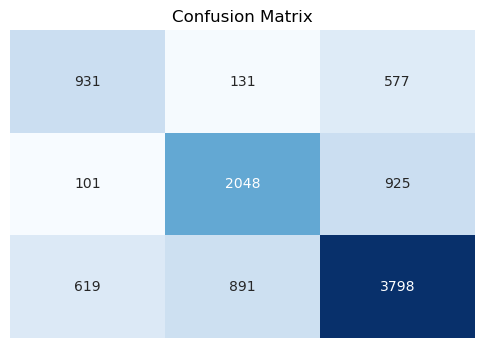

In [228]:
from sklearn import tree, metrics
import seaborn as sns 
import matplotlib.pyplot as plt

# makes a decision tree using x/y train data
dtc = tree.DecisionTreeClassifier().fit(x_train, y_train)

# use model for pred
y_pred_dtc = dtc.predict(x_test)

# getting statistics
accuracy = metrics.accuracy_score(y_test, y_pred_dtc)
# precision = metrics.precision_score(y_test, y_pred_dtc)
# recall = metrics.recall_score(y_test, y_pred_dtc)
# f1 = metrics.f1_score(y_test, y_pred_dtc)
cm = metrics.confusion_matrix(y_test, y_pred_dtc)

print(f'accuracy : {accuracy}')
# print(f'precision : {precision}')
# print(f'recall : {recall}')
# print(f'f1 : {f1}')
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.7671889033030636
[[1138   23  478]
 [  65 2385  624]
 [ 458  685 4165]]


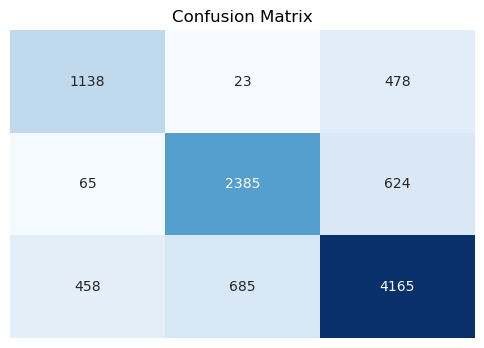

In [231]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
rfc = rfc.fit(x_train, y_train)

y_pred_rfc = rfc.predict(x_test)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, y_pred_rfc)
# precision = metrics.precision_score(y_test, y_pred_rfc)
# recall = metrics.recall_score(y_test, y_pred_rfc)
# f1 = metrics.f1_score(y_test, y_pred_rfc)
cm = metrics.confusion_matrix(y_test, y_pred_rfc)

# Print the results
print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 score:', f1)
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [234]:
from sklearn import neighbors
# Create a KNN classifier and fit it to the training data
knn = neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(x_test)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, y_pred)
# precision = metrics.precision_score(y_test, y_pred)
# recall = metrics.recall_score(y_test, y_pred)
# f1 = metrics.f1_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred_rfc)

# Print the results
print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 score:', f1)
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].